# Integrate over multiple features

## This script should be run after feature selection is finished within each datatypes

In [4]:
%matplotlib inline
import pymysql as mdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# connect to mysql db
con = mdb.connect('localhost', 'root', '', 'RNAseq1') #host, user, password, #database

In [6]:
# connect to IDKey
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM IDKey;") # AMP-AD_ROSMAP_Rush-Broad_IDKey.csv
    rows = cur.fetchall()

# load IDKey
colnames = tuple([desc[0] for desc in cur.description])
idkey = pd.DataFrame(list(rows),columns=colnames)
idkey = idkey.set_index(idkey.projid)
idkey = idkey.drop(['projid', 'ind'], axis=1)

In [7]:
# get samples with microrna,mwas,mrna data
allids = idkey.loc[(idkey.mirna_data==1)&(idkey.mwas_data==1)&(idkey.mrna_data==1),].index
#len(allids)

In [8]:
# connect to Clinical data
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM Clinical;") # AMP-AD_ROSMAP_Rush-Broad_Clinical.csv
    rows = cur.fetchall()

# load Clinical data
colnames = tuple([desc[0] for desc in cur.description])
clin = pd.DataFrame(list(rows),columns=colnames)
clin = clin.set_index(clin.projid)
clin = clin.drop(['projid','ind'], axis=1)
#len(clin)

In [9]:
# print clinical variations in sorted order
allclin = clin[clin.index.isin(list(allids))]
#allclin

In [10]:
# remove samples with cogdx values 0,3,5,6
allclin = allclin.loc[allclin['cogdx'].isin([1,2,4])]
allclin = pd.DataFrame.sort_index(allclin)
#len(allclin)

In [12]:
mwas = pd.DataFrame.from_csv("mwas_degs.csv") # feature selection results from DNA methylation
mirna = pd.DataFrame.from_csv("mirna_sorted_degs.csv") # feature selection results from micro RNA
mrna = pd.DataFrame.from_csv("fpkm_mrna_degs.csv") # feature selection results from mRNA expression

In [13]:
mrna = mrna.T[mrna.T.index.isin(allids.map(unicode))]
mrna.shape

(477, 936)

In [14]:
mwas = mwas.T[mwas.T.index.isin(allids.map(unicode))]
mwas.shape

(477, 71)

In [15]:
mirna = mirna.T[mirna.T.index.isin(allids.map(unicode))]
mirna.shape

(477, 29)

In [16]:
# all molecular features
all_data = pd.concat([mrna,mirna,mwas],axis=1)

In [17]:
# add clinical features
test = allclin.loc[:,['msex','apoe_genotype','age_death']]
del test.index.name
test.columns.name = u'Genes'

In [21]:
# age of death is capped at 90+, should change them to 90
test = pd.DataFrame.replace(test,"90+",90)
test = test[test.index.isin(allclin.index)]
test = test.sort_index()

In [18]:
# headers of molecular features are in unicode, they must be decoded in order to map with clinical features
# decode unicode index in mirna
str_index = [int(x) for x in mirna.index]
tmp = dict(zip(mirna.index, str_index))
mirna_tmp = pd.DataFrame.rename(mirna,index=tmp)

In [19]:
# decode unicode index in mwas
str_index = [int(x) for x in mwas.index]
tmp = dict(zip(mwas.index, str_index))
mwas_tmp = pd.DataFrame.rename(mwas,index=tmp)

In [22]:
# decode unicode index in mwas
str_index = [int(x) for x in mrna.index]
tmp = dict(zip(mrna.index, str_index))
mrna_tmp = pd.DataFrame.rename(mrna,index=tmp)
#mrna_tmp.index

In [24]:
all_data2 = pd.concat([mrna_tmp,mirna_tmp,mwas_tmp,test],axis=1)

# 1. Let's plot some plots

## 1.1 PCA and LDA of samples

In [25]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = pd.DataFrame.as_matrix(all_data)

y = pd.Series.as_matrix(allclin.cogdx)
y = np.array([0 if x == 1 else x for x in y])
y = np.array([1 if x == 2 else x for x in y])
y = np.array([2 if x == 4 else x for x in y])

z = np.concatenate([np.repeat(0,936),np.repeat(1,71),np.repeat(2,29)])

target_names = np.array(["control","MCI","AZ"])
X.shape
z.shape
target_names2 = np.array(["mRNA","microRNA","DNA Methylation"])

In [26]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


explained variance ratio (first two components): [ 0.90792596  0.04181563]


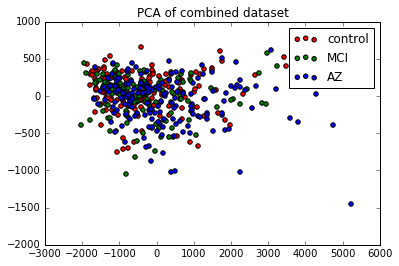

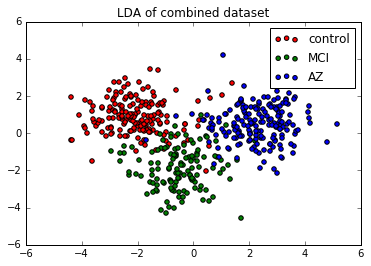

In [27]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of combined dataset')
fig.savefig('all_PCA.jpg', bbox_inches='tight')

fig = plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of combined dataset')
fig.savefig('all_LDA.jpg', bbox_inches='tight')

plt.show()

## 1.2 PCA and LDA of features

In [28]:
pca = PCA(n_components=2)
X_r = pca.fit(X.T).transform(X.T)
lda = LDA(n_components=2)
X_r2 = lda.fit(X.T, z).transform(X.T)

explained variance ratio (first two components): [ 0.95472974  0.02989264]


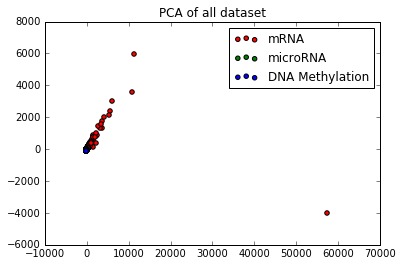

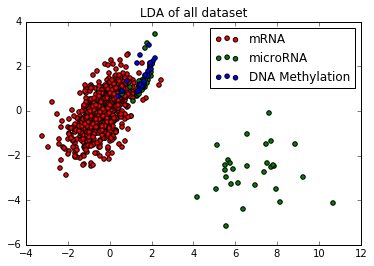

In [29]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names2):
    plt.scatter(X_r[z == i, 0], X_r[z == i, 1], c=c, label=target_name)
#for n in range(len(X_r)):
#    plt.text(X_r[n, 0],X_r[n, 1],str(all_data.T.index[n]))
plt.legend()
plt.title('PCA of all dataset')
fig.savefig('all_features_PCA.pdf', bbox_inches='tight')

fig = plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names2):
    plt.scatter(X_r2[z == i, 0], X_r2[z == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of all dataset')
fig.savefig('all_features_LDA.pdf', bbox_inches='tight')

plt.show()

# 2. Prediction

## 2.1 Set up cross-validation and test set

In [31]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc

labels = allclin['cogdx'].values.tolist()
bin_labels = [1 if x == 4 else 0 for x in labels]

## set train set and test set
(X_train, X_test, y_train, y_test) = train_test_split(all_data,bin_labels,test_size=0.2,stratify=labels,random_state=0)

# set 5X crossvalidation within train set
slo = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=0)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.lda import LDA
from sklearn.metrics import roc_curve, auc

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


## 2.2 Run prediction on all three molecular features combined

In [33]:
# Random Forest
params = [{'n_estimators': [10,50,100,200,300,400,500,1000]}]
rf = GridSearchCV(RandomForestClassifier(), params, cv =slo, scoring='roc_auc')
rf.fit(X_train, y_train)
rf = rf.best_estimator_
print("Random Forest accuracy = {}".format(rf.score(X_test,y_test)))

Random Forest accuracy = 0.708333333333


In [34]:
rf.n_estimators

400

In [35]:
rf_score = rf.predict_proba(X_test)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf_score[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc

0.69629629629629641

In [36]:
# Elastic Net
params = [{'l1_ratio': [0,0.25,0.5,0.75,1], 'alpha': [0.01,0.1,1,10,100,1000]}]
el = GridSearchCV(ElasticNet(), params, cv = slo, scoring='roc_auc')
el.fit(X_train, y_train)
el = el.best_estimator_
print("Elastic Net accuracy = {}".format(el.score(X_test,y_test)))

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Elastic Net accuracy = 0.202612124708


In [37]:
print(el.l1_ratio)
print(el.alpha)

0.25
1


In [38]:
el_score = el.decision_function(X_test)
el_fpr, el_tpr, el_thresholds = roc_curve(y_test,el_score)
el_roc_auc = auc(el_fpr, el_tpr)
el_roc_auc

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


0.76574074074074072

In [39]:
# LDA
params = [{'solver': ['svd','lsqr']}]
lda = GridSearchCV(LDA(), params, cv=slo, scoring='roc_auc')
lda.fit(X_train, y_train)
lda = lda.best_estimator_
print("LDA accuracy = {}".format(lda.score(X_test,y_test)))

LDA accuracy = 0.697916666667


In [40]:
lda.solver

'svd'

In [41]:
lda_score = lda.decision_function(X_test)
lda_fpr, lda_tpr, lda_thresholds = roc_curve(y_test,lda_score)
lda_roc_auc = auc(lda_fpr, lda_tpr)
lda_roc_auc

0.80787037037037035

In [42]:
# Logistic Regression
params = [{'solver': ['newton-cg','lbfgs','liblinear','sag']}]
lr = GridSearchCV(LogisticRegression(), params, cv=slo, scoring='roc_auc')
lr.fit(X_train, y_train)
lr = lr.best_estimator_
print("Logistic Regression accuracy = {}".format(lr.score(X_test,y_test)))

Logistic Regression accuracy = 0.708333333333


/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [43]:
lr.solver

'sag'

In [44]:
lr_score = lr.decision_function(X_test)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test,lr_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_roc_auc

0.71203703703703702

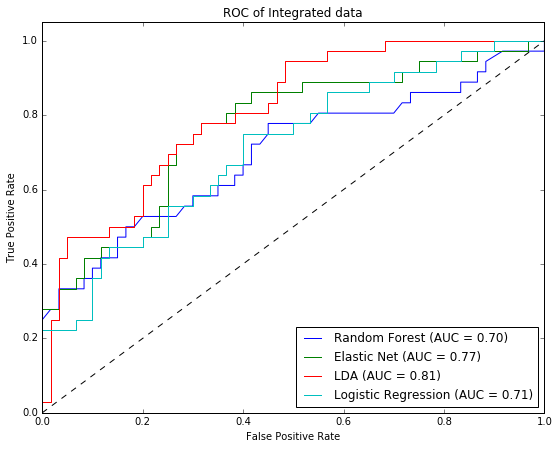

In [45]:
# Plot ROC curve
fig = plt.figure(1, figsize=(9, 7))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot(el_fpr, el_tpr, label='Elastic Net (AUC = %0.2f)' % el_roc_auc)
plt.plot(lda_fpr, lda_tpr, label='LDA (AUC = %0.2f)' % lda_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Integrated data')
plt.legend(loc="lower right")

fig.savefig('Integreated.ROC.jpg', bbox_inches='tight')
plt.show()

## 2.3 Run prediction on all three molecular features plus clinical features

In [46]:
# set train set and test set
(X_train, X_test, y_train, y_test) = train_test_split(all_data2,bin_labels,test_size=0.2,stratify=labels,random_state=0)

# set 5X crossvalidation within train set
slo = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=0)

In [47]:
# Random Forest
params = [{'n_estimators': [10,50,100,200,300,400,500,1000]}]
rf = GridSearchCV(RandomForestClassifier(), params, cv =slo, scoring='roc_auc')
rf.fit(X_train, y_train)
rf = rf.best_estimator_
print("Random Forest accuracy = {}".format(rf.score(X_test,y_test)))
rf_score = rf.predict_proba(X_test)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf_score[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc

Random Forest accuracy = 0.6875


0.69050925925925921

In [48]:
# Elastic Net
params = [{'l1_ratio': [0,0.25,0.5,0.75,1], 'alpha': [0.01,0.1,1,10,100,1000]}]
el = GridSearchCV(ElasticNet(), params, cv = slo, scoring='roc_auc')
el.fit(X_train, y_train)
el = el.best_estimator_
print("Elastic Net accuracy = {}".format(el.score(X_test,y_test)))
el_score = el.decision_function(X_test)
el_fpr, el_tpr, el_thresholds = roc_curve(y_test,el_score)
el_roc_auc = auc(el_fpr, el_tpr)
el_roc_auc

Elastic Net accuracy = 0.118827893507


/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


0.76249999999999996

In [49]:
# LDA
params = [{'solver': ['svd','lsqr']}]
lda = GridSearchCV(LDA(), params, cv=slo, scoring='roc_auc')
lda.fit(X_train, y_train)
lda = lda.best_estimator_
print("LDA accuracy = {}".format(lda.score(X_test,y_test)))
lda_score = lda.decision_function(X_test)
lda_fpr, lda_tpr, lda_thresholds = roc_curve(y_test,lda_score)
lda_roc_auc = auc(lda_fpr, lda_tpr)
lda_roc_auc

LDA accuracy = 0.71875


0.80972222222222223

In [50]:
# Logistic Regression
params = [{'solver': ['newton-cg','lbfgs','liblinear','sag']}]
lr = GridSearchCV(LogisticRegression(), params, cv=slo, scoring='roc_auc')
lr.fit(X_train, y_train)
lr = lr.best_estimator_
print("Logistic Regression accuracy = {}".format(lr.score(X_test,y_test)))
lr_score = lr.decision_function(X_test)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test,lr_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_roc_auc

Logistic Regression accuracy = 0.708333333333


/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/optimize.py:200: UserWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


0.71157407407407403

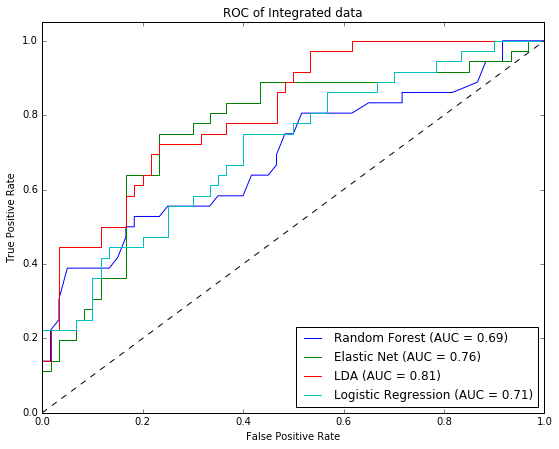

In [51]:
# Plot ROC curve
fig = plt.figure(1, figsize=(9, 7))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot(el_fpr, el_tpr, label='Elastic Net (AUC = %0.2f)' % el_roc_auc)
plt.plot(lda_fpr, lda_tpr, label='LDA (AUC = %0.2f)' % lda_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Integrated data')
plt.legend(loc="lower right")

fig.savefig('Integreated.plus_clinical.ROC.jpg', bbox_inches='tight')
plt.show()

In [56]:
# rough idea of feature importance
rf.fit(all_data, bin_labels)
names = all_data.columns
#print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)

[(0.0126, 'hsa-miR-132'), (0.0055, 'hsa-miR-129-5p'), (0.0053, 'ENSG00000196415.4'), (0.0049, 'ENSG00000155980.6'), (0.0042, 'cg05731218'), (0.0041, 'ENSG00000125534.4'), (0.004, 'ENSG00000105419.11'), (0.0039, 'ENSG00000142765.12'), (0.0039, 'ENSG00000053702.10'), (0.0038, 'cg05066959'), (0.0037, 'ENSG00000086159.8'), (0.0035, 'ENSG00000168743.8'), (0.0034, 'cg26407544'), (0.0034, 'cg13076843'), (0.0033, 'cg12307200'), (0.0033, 'cg12114584'), (0.0033, 'ENSG00000116786.7'), (0.0032, 'ENSG00000088836.7'), (0.0031, 'cg03169557'), (0.003, 'cg18556455'), (0.003, 'cg10920329'), (0.003, 'ENSG00000144057.11'), (0.0029, 'cg23968456'), (0.0029, 'ENSG00000111181.8'), (0.0028, 'cg22883290'), (0.0028, 'cg12877335'), (0.0027, 'cg27443779'), (0.0027, 'cg18343862'), (0.0027, 'cg13639901'), (0.0027, 'cg07012687'), (0.0027, 'ENSG00000249436.1'), (0.0027, 'ENSG00000154864.7'), (0.0026, 'ENSG00000198624.8'), (0.0026, 'ENSG00000180777.9'), (0.0026, 'ENSG00000170276.4'), (0.0026, 'ENSG00000132357.9'), (0.0

Feature ranking:


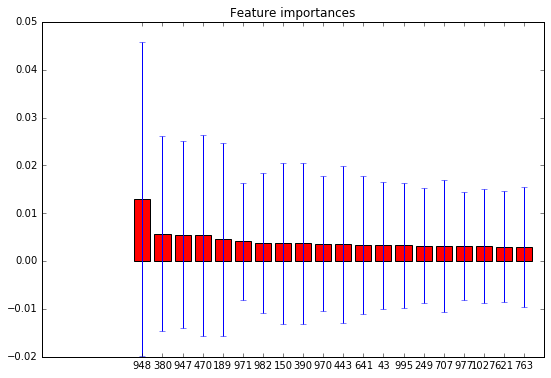

In [57]:
# try to plot feature importance
orest = rf.fit(all_data, bin_labels)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1] #tmp2 = take(100, tmp.iteritems())

# Print the feature ranking
print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(1, figsize=(9, 6))
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.bar(range(20), importances[indices[0:20]], color="r", yerr=std[indices[0:20]], align="center")

#plt.xticks(range(X.shape[1]), indices)
plt.xticks(range(20), indices[0:20])

#plt.xlim([-1, X.shape[1]])
#plt.xlim([-1, 20])

plt.show()

## 2.4 Testing loss of prediction power when a feature is removed

In [52]:
data_tmp = pd.concat([mrna,mwas],axis=1) # remove each feature here

In [53]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc

## set train set and test set
(X_train, X_test, y_train, y_test) = train_test_split(data_tmp,bin_labels,test_size=0.2,stratify=labels,random_state=0)

# set 5X crossvalidation within train set
slo = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=0)

In [54]:
# Random Forest
params = [{'n_estimators': [10,50,100,200,300,400,500,1000]}]
rf = GridSearchCV(RandomForestClassifier(), params, cv =slo, scoring='roc_auc')
rf.fit(X_train, y_train)
rf = rf.best_estimator_
print("Random Forest accuracy = {}".format(rf.score(X_test,y_test)))
print("number of trees: {}".format(rf.n_estimators))
rf_score = rf.predict_proba(X_test)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf_score[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Elastic Net
params = [{'l1_ratio': [0,0.25,0.5,0.75,1], 'alpha': [0.01,0.1,1,10,100,1000]}]
el = GridSearchCV(ElasticNet(), params, cv = slo, scoring='roc_auc')
el.fit(X_train, y_train)
el = el.best_estimator_
print("Elastic Net accuracy = {}".format(el.score(X_test,y_test)))
print("l1_ratio: {}".format(el.l1_ratio))
print("alpha: {}".format(el.alpha))
el_score = el.decision_function(X_test)
el_fpr, el_tpr, el_thresholds = roc_curve(y_test,el_score)
el_roc_auc = auc(el_fpr, el_tpr)

# LDA
params = [{'solver': ['svd','lsqr']}]
lda = GridSearchCV(LDA(), params, cv=slo, scoring='roc_auc')
lda.fit(X_train, y_train)
lda = lda.best_estimator_
print("LDA accuracy = {}".format(lda.score(X_test,y_test)))
lda_score = lda.decision_function(X_test)
lda_fpr, lda_tpr, lda_thresholds = roc_curve(y_test,lda_score)
lda_roc_auc = auc(lda_fpr, lda_tpr)

# Logistic Regression
params = [{'solver': ['newton-cg','lbfgs','liblinear','sag']}]
lr = GridSearchCV(LogisticRegression(), params, cv=slo, scoring='roc_auc')
lr.fit(X_train, y_train)
lr = lr.best_estimator_
print("Logistic Regression accuracy = {}".format(lr.score(X_test,y_test)))
lr_score = lr.decision_function(X_test)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test,lr_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)

Random Forest accuracy = 0.697916666667
number of trees: 1000
Elastic Net accuracy = 0.202612124708
l1_ratio: 0.25
alpha: 1
LDA accuracy = 0.71875
Logistic Regression accuracy = 0.708333333333


/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


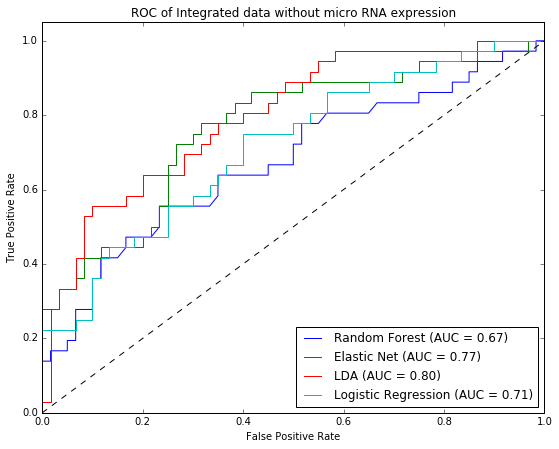

In [55]:
# Plot ROC curve
fig = plt.figure(1, figsize=(9, 7))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot(el_fpr, el_tpr, label='Elastic Net (AUC = %0.2f)' % el_roc_auc)
plt.plot(lda_fpr, lda_tpr, label='LDA (AUC = %0.2f)' % lda_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Integrated data without micro RNA expression') # change plot title here
plt.legend(loc="lower right")

fig.savefig('no_miRNA.ROC.jpg', bbox_inches='tight') # change file name here
plt.show()

# 3. Plotting my results

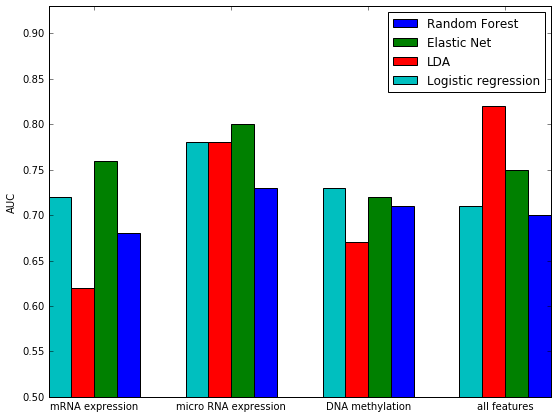

In [364]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
ind = np.arange(4)*3  # the x locations for the groups
width = 0.5      # the width of the bars

fig = plt.figure(1, figsize=(9, 7))
ax = fig.add_subplot(111)

yvals = [0.72, 0.78, 0.73, 0.71]
rects1 = ax.bar(ind-1, yvals, width, color='c')
zvals = [0.62,0.78,0.67, 0.82]
rects2 = ax.bar(ind+width-1, zvals, width, color='r')
kvals = [0.76, 0.80, 0.72, 0.75]
rects3 = ax.bar(ind+width*2-1, kvals, width, color='g')
qvals = [0.68, 0.73, 0.71, 0.70]
rects4 = ax.bar(ind+width*3-1, qvals, width, color='b')

plt.ylim([0.5, 0.93])
plt.xlim([-1, 10])

ax.set_ylabel('AUC')
ax.set_xticks(ind+width*3-1.5)
ax.set_xticklabels( ('mRNA expression', 'micro RNA expression', 'DNA methylation', 'all features') )
ax.legend( (rects4[0], rects3[0], rects2[0], rects1[0]), ('Random Forest','Elastic Net', 'LDA', 'Logistic regression') )

fig.savefig('all_feature_AUC.jpg', bbox_inches='tight')
plt.show()


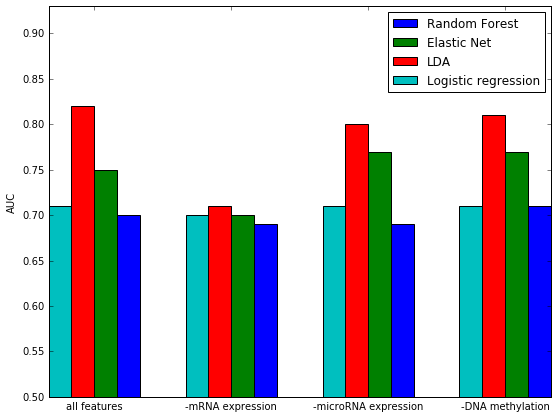

In [365]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
ind = np.arange(4)*3  # the x locations for the groups
width = 0.5      # the width of the bars

fig = plt.figure(1, figsize=(9, 7))
ax = fig.add_subplot(111)

yvals = [0.71, 0.70, 0.71, 0.71]
rects1 = ax.bar(ind-1, yvals, width, color='c')
zvals = [0.82,0.71,0.80, 0.81]
rects2 = ax.bar(ind+width-1, zvals, width, color='r')
kvals = [0.75, 0.70, 0.77, 0.77]
rects3 = ax.bar(ind+width*2-1, kvals, width, color='g')
qvals = [0.70, 0.69, 0.69, 0.71]
rects4 = ax.bar(ind+width*3-1, qvals, width, color='b')

plt.ylim([0.5, 0.93])
plt.xlim([-1, 10])

ax.set_ylabel('AUC')
ax.set_xticks(ind+width*3-1.5)
ax.set_xticklabels( ('all features', '-mRNA expression', '-microRNA expression', '-DNA methylation') )
ax.legend( (rects4[0], rects3[0], rects2[0], rects1[0]), ('Random Forest', 'Elastic Net', 'LDA', 'Logistic regression') )

fig.savefig('all_feature_AUC.2.jpg', bbox_inches='tight')
plt.show()


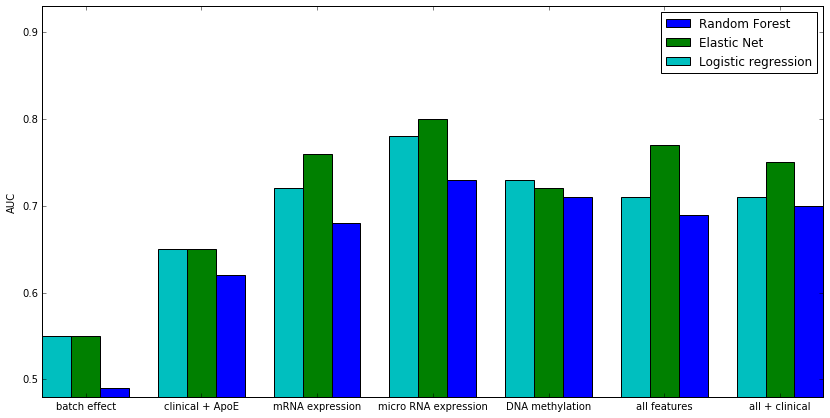

In [372]:
import numpy as np
import matplotlib.pyplot as plt

N = 7
ind = np.arange(N)*2  # the x locations for the groups
width = 0.5      # the width of the bars

fig = plt.figure(1, figsize=(14, 7))
ax = fig.add_subplot(111)

avals = [0.55, 0.65, 0.72, 0.78, 0.73, 0.71, 0.71] # logistic regression
rects1 = ax.bar(ind-1, avals, width, color='c')
#bvals = [0.55, 0.65, 0.62, 0.78, 0.67, 0.82] # LDA
#rects2 = ax.bar(ind+width-1, bvals, width, color='r')
cvals = [0.55, 0.65, 0.76, 0.80, 0.72, 0.77, 0.75] # Elastic Net
rects3 = ax.bar(ind+width*1-1, cvals, width, color='g')
dvals = [0.49, 0.62, 0.68, 0.73, 0.71, 0.69, 0.70] # Random Forest
rects4 = ax.bar(ind+width*2-1, dvals, width, color='b')

plt.ylim([0.48, 0.93])
plt.xlim([-1, 12.5])

ax.set_ylabel('AUC')
ax.set_xticks(ind+width*3-1.75)
ax.set_xticklabels( ('batch effect', 'clinical + ApoE', 'mRNA expression', 'micro RNA expression', 'DNA methylation', 'all features', "all + clinical") )
ax.legend( (rects4[0], rects3[0], rects1[0]), ('Random Forest','Elastic Net', 'Logistic regression') )
''
fig.savefig('all_feature_AUC.v4.jpg', bbox_inches='tight')
plt.show()


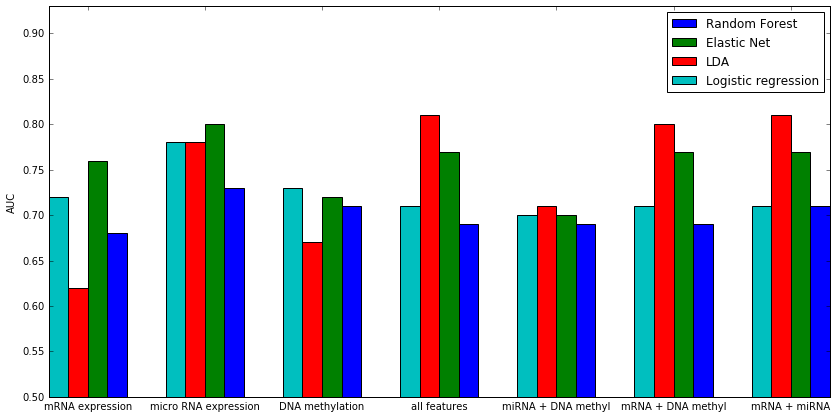

In [8]:
import numpy as np
import matplotlib.pyplot as plt

N = 7
ind = np.arange(N)*3  # the x locations for the groups
width = 0.5      # the width of the bars

fig = plt.figure(1, figsize=(14, 7))
ax = fig.add_subplot(111)

avals = [0.72, 0.78, 0.73, 0.71, 0.70, 0.71, 0.71] # logistic regression
rects1 = ax.bar(ind-1, avals, width, color='c')
bvals = [0.62, 0.78, 0.67, 0.81, 0.71, 0.80, 0.81] # LDA
rects2 = ax.bar(ind+width-1, bvals, width, color='r')
cvals = [0.76, 0.80, 0.72, 0.77, 0.70, 0.77, 0.77] # Elastic Net
rects3 = ax.bar(ind+width*2-1, cvals, width, color='g')
dvals = [0.68, 0.73, 0.71, 0.69, 0.69, 0.69, 0.71] # Random Forest
rects4 = ax.bar(ind+width*3-1, dvals, width, color='b')

plt.ylim([0.5, 0.93])
plt.xlim([-1, 19])

ax.set_ylabel('AUC')
ax.set_xticks(ind+width*3-1.5)
ax.set_xticklabels( ('mRNA expression', 'micro RNA expression', 'DNA methylation', 'all features', 'miRNA + DNA methyl', 'mRNA + DNA methyl', 'mRNA + miRNA') )
ax.legend( (rects4[0], rects3[0], rects2[0], rects1[0]), ('Random Forest','Elastic Net', 'LDA', 'Logistic regression') )

fig.savefig('all_feature_AUC.combined.jpg', bbox_inches='tight')
plt.show()
